# On a Closed-loop Controller for the Coevolutionary Model of Actions and Opinions via Broadcasting Information

Simulations for the paper titled "On a Closed-loop Controller for the Coevolutionary Model of Actions and Opinions via Broadcasting Information" by Raineri R, Ye M, and Zino L., submitted to European Control Conference 2026. 

In [4]:
import pandas as pd
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
import networkx as nx

## Network Initialization

The simulations have been implemented both both on generated synthetic networks — Erdos–Renyi (ER) random networks and Watts-Strogatz (WS) small-world networks— and on a real-world network associated with social contacts in a village in rural Malawi, whose dataset is available on Sociopatterns.

### Malawi Network 

In [13]:
# import data from file
malawi_data = pd.read_excel("malawi_edges.xlsx")
malawi_data.groupby(['Source', 'Target']).size() .sort_values(ascending=False).reset_index(name='weight')

,Source,Target,weight
0,55,62,4470
1,56,74,3767
2,4,84,3463
3,81,52,3166
4,49,45,3142
...,...,...,...
342,68,33,1
343,29,6,1
344,31,73,1
345,31,81,1


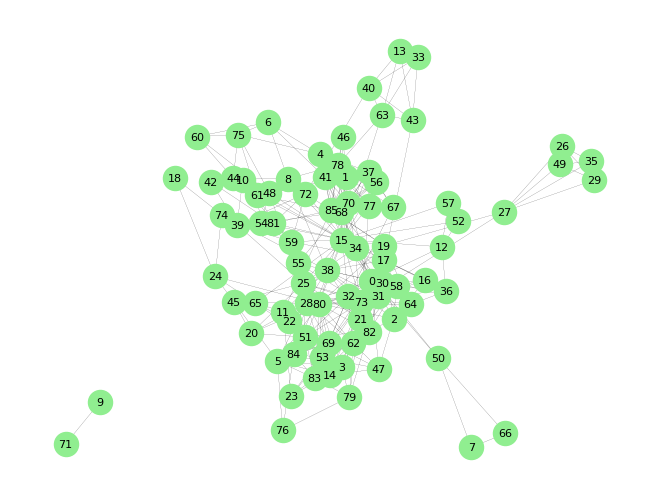

In [14]:
# create network structure
network = malawi_data.groupby(['Source', 'Target']).size() .sort_values(ascending=False) .reset_index(name='weight') #.drop_duplicates(subset='Target')
network["normalized_W"]=(network["weight"]-network["weight"].min())/(network["weight"].max()-network["weight"].min())+0.1
# collect all the nodes
nodes = pd.concat([network['Source'],network['Target']]).drop_duplicates().sort_values()
N = len(nodes)
# adj matrix
A_global = np.zeros((N,N)) #weighted
W = np.zeros((N,N)) #undirected adj matrix
for i in range(0,N):
    for j in range(0,N):
        if len(network[((network['Source'].values==i+1)&(network['Target'].values==j+1))])!=0:
            A_global[i,j]= network.loc[((network['Source'].values==i+1)&(network['Target'].values==j+1)), 'normalized_W'].iloc[0]
            W[i,j]=1
            W[j,i]=1
G = nx.Graph()
for i in range(N): 
 for j in range(N): 
   if W[i][j] != 0: 
      G.add_edge(i,j) 
      G.add_edge(j,i) 
pos = nx.spring_layout(G,seed=30, k=.3)
nx.draw(G,pos=pos,with_labels=True, node_size=300, font_size=8,node_color='lightgreen', width=.1) 
plt.show() 

Remove from the network nodes (9,71) in order to consider only the biggest connected component

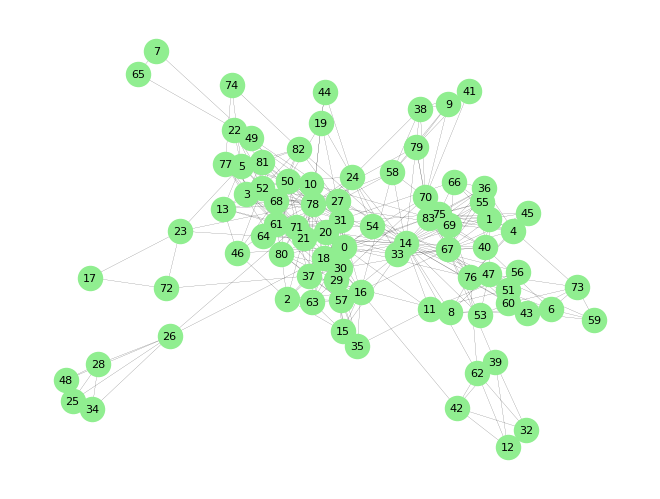

In [15]:
# define the biggest connected component 
W_connected= np.delete(W, [9, 71], 0)
W_connected = np.delete(W_connected, [9,71], 1)
Adj = (W_connected.T/ W_connected.sum(axis=1)).T
N = np.shape(W_connected)[0]
G = nx.Graph()
for i in range(N): 
 for j in range(N): 
   if W_connected[i][j] != 0: 
      G.add_edge(i,j) 
      G.add_edge(j,i) 
pos = nx.spring_layout(G,seed=1, k=.3)
#pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos=pos,with_labels=True, node_size=300, font_size=8,node_color='lightgreen', width=.1) 
plt.savefig('malawi_network')
plt.show() 

### Erdos-Renyi Random Graph

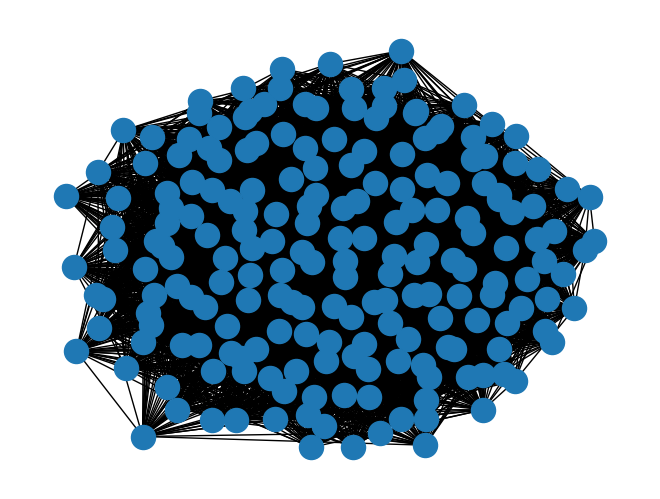

In [ ]:
N= 200
g = nx.erdos_renyi_graph(N,.3,21)
Adj = nx.adjacency_matrix(g)
Adj = Adj.toarray()
Adj = Adj/Adj.sum(axis=0)
Adj = (Adj.T/Adj.sum(axis=1)).T
G = nx.Graph()
for i in range(N): 
 for j in range(N): 
   if Adj[i][j] != 0: 
      G.add_edge(i,j) 
      G.add_edge(j,i) 
nx.draw(G) 
plt.show() 

### Watts-Strogatz Random Graph

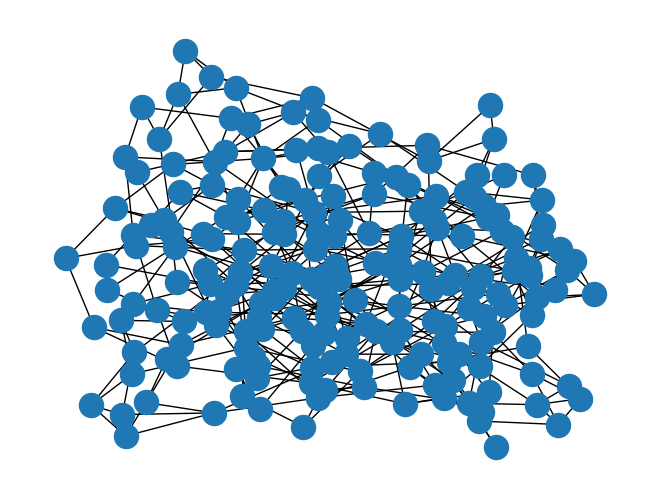

In [ ]:
N=200
g = nx.watts_strogatz_graph(N,int(np.ceil(0.02*N)),0.4)
Adj = nx.adjacency_matrix(g)
Adj = Adj.toarray()
Adj = Adj/Adj.sum(axis=0)
Adj = (Adj.T/Adj.sum(axis=1)).T
G = nx.Graph()
for i in range(N): 
 for j in range(N): 
   if Adj[i][j] != 0: 
      G.add_edge(i,j) 
      G.add_edge(j,i) 
nx.draw(G) 
plt.show() 

### Complete Graph

In [700]:
N = 50
g = nx.complete_graph(N)
Adj = nx.adjacency_matrix(g)
Adj = Adj.toarray()
Adj = (Adj.T/Adj.sum(axis=1)).T

## Algorithm Implementation

### Algorithm Design

In [16]:
def check_control(C: np.ndarray, x0: np.ndarray, W: np.ndarray, l: float, beta: float) -> bool:
    """
    Algorithm 1

    Checks if control in the graph is guaranteed when 'C' is the controlled set and 'x' is the actual state value of 'x' vector
    """
    I = np.eye(N)
    C = C.copy()
    B = I - ((1-l)*I) @ W
    M = np.linalg.inv(B)
    k = 1
    gamma = np.where(C == 1, np.ones(N), np.zeros(N)) #controlled actions 
    A = np.where(x0 == 1, np.ones(N), np.zeros(N)) #set of controlled nodes
    controlled = -1
    while ((controlled != A.sum())):
        x = np.where(A == 1, np.ones(N), -np.ones(N))
        y_next = M @ (l*I) @ x
        y = np.where(C==1, (1-l)*np.ones(N)+l*x, y_next)
        k +=1
        controlled = A.sum()

        delta = (2*beta*(1-l)*I) @ ((np.ones(N)-gamma)*I @ W @ y + gamma@I) + ((1-beta)*I) @ W @ x
        A[(A == 0) & (delta > 0)] = 1  
    return A.sum() == N # the graph is controlled if all the nodes flip their action

In [17]:
def optimal_set(W: np.ndarray, l: float, T: int, eps: float, C: np.ndarray, beta: float, x:np.ndarray) -> np.ndarray:
    """
    Algorithm 2

    Returns the minimal control set to reach full graph controllability in `T` iterations
    """
    C = C.copy()
    C_opt = C.copy()
    
    for i in tqdm.trange(T):
        r = random.randint(0, N-1)
        C_cand = C.copy()
        if C[r] == 1: # if 1 it is controlled
            C_cand[r]=0
            if check_control(C_cand,x, W, l, beta): # check if once removed it is still controlled
                C[r] = 0
                if C.sum() < C_opt.sum(): # if the new set is smaller than the actual optimum it is the new optimum
                    C_opt = C.copy()
        else:
            if random.uniform(0, 1) > eps:
                C[r] = 1 # flip back with prob eps
    
    return C_opt


In [18]:
def feedback_control(x:np.ndarray,y:np.ndarray,gamma:np.ndarray, t:int, T_rev:np.ndarray, W:np.ndarray, beta:float, l:float, R:np.ndarray):
    """
    Algorithm 3 

    Returns the new control input after revision
    """
    I = np.eye(N)
    if t in T_rev: #if t is a revision time
        A = np.where(x == 1, True, False) #set of flipped nodes
        C = np.where(gamma == 1, np.ones(N), np.zeros(N)) #set of controlled actions
        for i in np.arange(N):
            if C[i]==1:
                gamma_tmp = gamma.copy()
                gamma_tmp[i]=0
                y_new = np.min(y)*(1-l)*(np.ones(N)-gamma_tmp)*I + (1-l)*gamma_tmp+l*x
                delta = 2*beta*(1-l)*((np.ones(N)-gamma_tmp)*I@ W @ y_new + gamma_tmp)+ (1-beta)*W @x
                if np.all(delta[A]>0):
                    C_cand = C.copy()
                    C_cand[i]=0
                    if check_control(C_cand,x, W, l, beta):
                        gamma[i]=0
                        break
    #if we are not in a revision time we just do one extra step
    delta = (2*beta*(1-l)*((np.ones(N)-gamma)*I@ W @ y + gamma)+ (1-beta)*W @x)
    x_new = np.where(delta>0, 1, -1)
    x[R] = x_new[R]
    y[R] = ((1-l)*((np.ones(N)-gamma)*I@W@y+gamma) +l*x)[R]
    return x, y, gamma

In [19]:
def update_step(x:np.ndarray,y:np.ndarray,gamma:np.ndarray, W:np.ndarray, beta:float, l:float, R:np.ndarray):
    """
    Update step

    Returns the new values of x and y after the update
    """
    I = np.eye(N)
    delta = (2*beta*(1-l)*((np.ones(N)-gamma)*I@ W @ y + gamma)+ (1-beta)*W @x)
    x_new = np.where(delta>0, 1, -1)
    x[R] = x_new[R]
    y[R] = ((1-l)*((np.ones(N)-gamma)*I@W@y+gamma) +l*x)[R]
    return x, y

## Simulations

Preliminary, let us consider a generalized activation strategy where each node activates at least one in the interval $T_{max}$. The matrix $R$ indicates at each time instant which nodes are activated and which ones instead keep their previous value.

In [20]:
### SIMULATION SETTING
# parameter setting
l = 0.4 #lambda
eps = .8 #probability to flip back to guarantee wider exploration
beta = .6
#let's start controlling all the nodes
T = 10**4 #number of iterations
delta_t = 2 #interval between revisions
T_max = 300 #max revision time
T_rev = np.arange(0,T_max,delta_t) #revision times

# generate a random R matrix which indicate which nodes are activated at each time instant
# constraint: each node must be activated at least one
np.random.seed(21)
p_zero = .6
R = np.random.choice([0, 1], size=(N,T_max), p=[p_zero, 1-p_zero]) 
while (R.sum(axis=1)==0).any():
       R = np.random.choice([0, 1], size=(N,T_max), p=[p_zero, 1-p_zero])

In [21]:
# actual configuration
x = -np.ones(N) 
y = -np.ones(N)
# check the optimal controlled set at that step
C = np.ones(N)
gamma_init =optimal_set(Adj, l, T, eps, C, beta, x) # optimization using Algorithm 2
gamma = gamma_init.copy()
num_controlled = np.zeros(T_max) #vector of true revisions
err_y = np.zeros(T_max) #distance from opinion equilibrium
R = R.astype(bool)
T_opt = 0 #minimum time at which all the nodes flip
T_tilde_opt = 0 #time for eps-close to equilibrium
eps_eq = 10**(-4)
if check_control(gamma,x, Adj, l, beta):
    new_gamma = gamma.copy()
    x_final = x.copy()
    y_final = y.copy()
    num_controlled[0] = new_gamma.sum()
    err_y[0] = 2
    for t in range(1,T_max):
        R_t = R[:,t]
        x_final, y_final, new_gamma = feedback_control(x_final,y_final,new_gamma, t, T_rev, Adj, beta, l, R_t)
        num_controlled[t] = new_gamma.sum()
        err_y[t]=np.abs(np.min(y_final)-1)
        if ((x_final.sum()==N) and (T_opt==0)):
            T_opt=t
        if (np.abs(np.min(y_final)-1)<=eps_eq) and (T_tilde_opt==0):
            T_tilde_opt = t
else:
    print('Unable to control')

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:09<00:00, 1000.48it/s]


In [ ]:
## Dynamics without control 

# actual configuration
x = -np.ones(N) 
y = -np.ones(N)
# check the optimal controlled set at that step
T_opt_noFeed = 0 #minimum time at which all the nodes flip
T_tilde_opt_noFeed = 0
R = R.astype(bool)
err_y_noFeed = np.zeros(T_max)
if check_control(gamma_init,x, Adj, l, beta):
    x_final_noFeed = x.copy()
    y_final_noFeed = y.copy()
    err_y_noFeed[0]=2
    for t in range(T_max):
        R_t = R[:,t]
        x_final_noFeed, y_final_noFeed = update_step(x_final_noFeed,y_final_noFeed,gamma, Adj, beta, l, R_t)
        err_y_noFeed[t]=np.abs(np.min(y_final_noFeed)-1)
        if ((x_final_noFeed.sum()==N) and (T_opt_noFeed==0)):
            T_opt_noFeed=t
        if (np.abs(np.min(y_final_noFeed)-1)<=eps_eq) and (T_tilde_opt_noFeed==0):
            T_tilde_opt_noFeed = t
else:
    print('Unable to control')

Let us plot the control policy as function of time. It wants to underline how we turn off the control policy over time. The red point indicated the first time instant at which all the actions are flipped to $+1$. The subsequent policy is done just to reach stability.

In [1406]:
print('Time to complete control on actions with Feedback', T_opt, 'vs without Feedback', T_opt_noFeed)
print('Time to be eps-close to complete control on opinions with Feedback', T_tilde_opt, 'vs without Feedback', T_tilde_opt_noFeed)

Time to complete control on actions with Feedback 53 vs without Feedback 53
Time to be eps-close to complete control on opinions with Feedback 96 vs without Feedback 89


In [1407]:
total_cost = np.sum(num_controlled[:T_tilde_opt])
print('Total cost with feedback for eps-optimality', total_cost)
total_cost_noFeed = np.sum(gamma_init)*T_tilde_opt_noFeed
print('Total cost without feedback for eps-optimality', total_cost_noFeed)

Total cost with feedback for eps-optimality 858.0
Total cost without feedback for eps-optimality 1157.0


final number of control actions with Feedback: 13.0 out of 84
number of control actions without Feedback: 13.0 out of 84


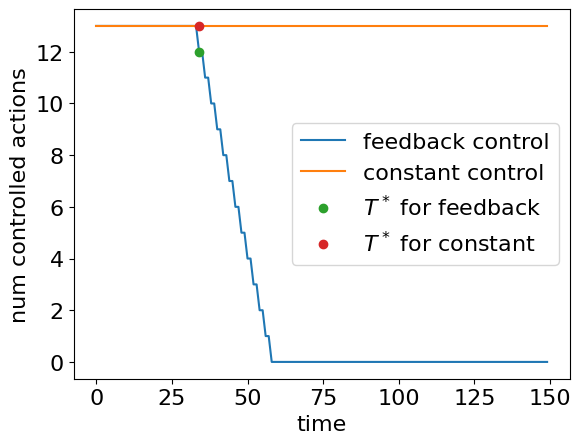

In [1414]:
print('final number of control actions with Feedback:', gamma.sum(), 'out of', N)
print('number of control actions without Feedback:', gamma_init.sum(), 'out of', N)
plt.plot(num_controlled[:150], label='feedback control')
plt.plot((gamma_init.sum())*np.ones(T_max)[:150], label='constant control')
plt.plot(T_opt, num_controlled[T_opt],'o', label='$T^*$ for feedback')
plt.plot(T_opt_noFeed, gamma_init.sum(),'o', label='$T^*$ for constant')
#plt.plot(T_tilde_opt, num_controlled[T_tilde_opt],'g*', label='$\\tilde{T}$ for feedback')
#plt.plot(T_tilde_opt_noFeed, gamma_init.sum(),'r*', label='$\\tilde{T}$ for fixed')
plt.xlabel("time")
plt.ylabel("num controlled actions")
plt.rcParams.update({'font.size': 16})
plt.legend()

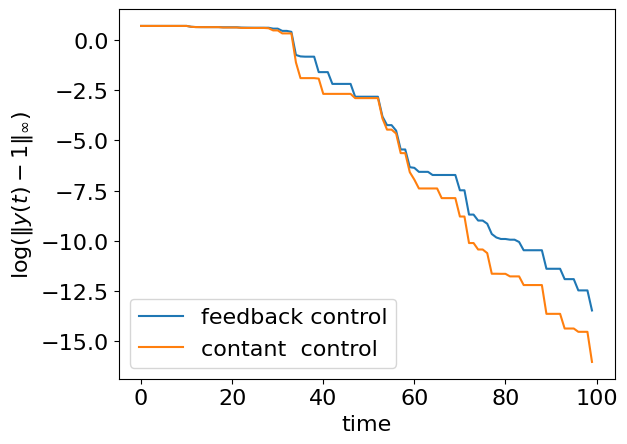

In [1415]:
plt.plot(np.log(err_y[:100]), label='feedback control')
plt.plot(np.log(err_y_noFeed[:100]), label='contant  control')
plt.xlabel("time")
plt.ylabel("$\log(\|y(t)-1\|_\infty)$")
plt.rcParams.update({'font.size': 16})
plt.legend()

Comparison for different revision intervals

100%|██████████| 10000/10000 [00:19<00:00, 525.98it/s]


here
[0.30188679 0.14622642 0.06132075 0.06132075 0.04874214 0.04874214]


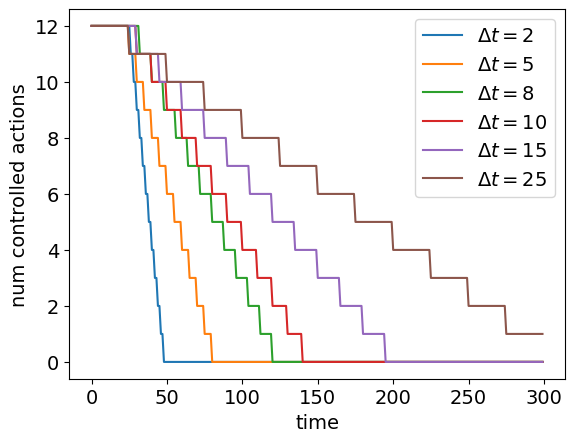

In [1363]:
# actual configuration
delta_t=[2, 5, 8, 10, 15,25]
x = -np.ones(N) 
y = -np.ones(N)
# check the optimal controlled set at that step
#gamma = np.ones(N)
C = np.ones(N)
gamma_init =optimal_set(Adj, l, T, eps, C, beta, x) # optimization using Algorithm 2
gamma = gamma_init.copy()
eps_eq = 10**(-4)
error = np.zeros(np.shape(delta_t)[0])
if check_control(gamma,x, Adj, l, beta):
    print('here')
    i=0
    for delta in delta_t:
        num_controlled = np.zeros(T_max) #vector of true revisions
        err_y = np.zeros(T_max) #distance from opinion equilibrium
        T_opt = 0 #minimum time at which all the nodes flip
        T_tilde_opt = 0 #time for eps-close to equilibrium
        T_rev = np.arange(0,T_max,delta)
        new_gamma = gamma.copy()
        x_final = x.copy()
        y_final = y.copy()
        num_controlled[0] = new_gamma.sum()
        err_y[0] = 2
        for t in range(1,T_max):
            R_t = R[:,t]
            x_final, y_final, new_gamma = feedback_control(x_final,y_final,new_gamma, t, T_rev, Adj, beta, l, R_t)
            num_controlled[t] = new_gamma.sum()
            err_y[t]=np.abs(np.min(y_final)-1)
            if ((x_final.sum()==N) and (T_opt==0)):
                T_opt=t
            if (np.abs(np.min(y_final)-1)<=eps_eq) and (T_tilde_opt==0):
                T_tilde_opt = t
        plt.plot(num_controlled, label=rf'$\Delta t={delta}$')
        total_cost = np.sum(num_controlled[:T_tilde_opt])
        total_cost_noFeed = np.sum(gamma_init)*T_tilde_opt_noFeed
        error[i] = (total_cost_noFeed - total_cost)/total_cost_noFeed
        i+=1
        #plt.plot(T_opt, num_controlled[T_opt],'o')
else:
    print('Unable to control')
plt.xlabel("time")
plt.ylabel("num controlled actions")
plt.rcParams.update({'font.size': 14})
plt.legend()
print(error)


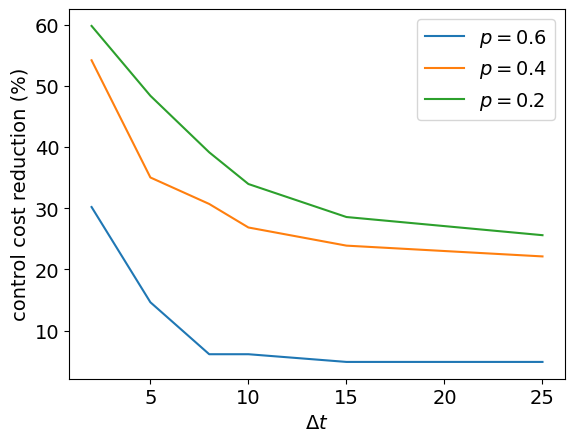

In [1368]:
# plot for different cost depending on probability of activation p 
plt.plot(delta_t, error04*100, label='$p=0.6$')
plt.plot(delta_t, error06*100, label='$p=0.4$')
plt.plot(delta_t, error08*100, label='$p=0.2$')
plt.xlabel("$\Delta t$")
plt.ylabel("control cost reduction (%)")
plt.rcParams.update({'font.size': 14})
plt.legend()